# Model Interpretability

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:
# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (BaggingClassifier, RandomForestClassifier) 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.svm import SVC

# metrics
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, recall_score, log_loss
from sklearn.metrics import brier_score_loss, matthews_corrcoef
from scipy.stats import ks_2samp

from sklearn.model_selection import cross_val_score

In [3]:
classifiers = {}
classifiers.update({'KNN': KNeighborsClassifier()})

classifiers.update({'GNB': GaussianNB()})

classifiers.update({'LGR': LogisticRegression(class_weight='balanced')})

classifiers.update({'SVC': SVC(class_weight='balanced', probability=True)})

classifiers.update({'Decisiontree': DecisionTreeClassifier(class_weight='balanced')})

classifiers.update({'Extratree': ExtraTreesClassifier(class_weight='balanced', 
                                                      n_estimators=250)})

classifiers.update({'Bagging': BaggingClassifier(DecisionTreeClassifier(),
                                                 n_estimators=100)})

classifiers.update({'Random Forest': RandomForestClassifier(class_weight='balanced',
                                                            n_estimators=100)})

classifiers.update({'AdaBoost': AdaBoostClassifier(n_estimators=100)})

classifiers.update({'Gradient Boosting': GradientBoostingClassifier(n_estimators=100,
                                                                 max_depth=2)})

In [4]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns= data.feature_names)
y = data.target

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=11)

In [6]:
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

from tqdm import tqdm_notebook
kf = KFold(n_splits=3)
results = {}

for classifier_label, classifier in tqdm_notebook(classifiers.items()):
    steps = [('classifier', classifier)]            # 튜플 형태로 파이프라인 구성
    pipeline = Pipeline(steps = steps)
    param_grid = {}
    
    gs = RandomizedSearchCV(pipeline, param_grid, cv = kf,
                            n_iter = 1,
                            scoring = 'f1_macro')  
    y_pred = gs.fit(X_train, y_train).predict(X_test)
    y_proba = gs.predict_proba(X_test)
    y_score = y_proba[:,1]
    
    result = {'Best Parameters': gs.best_params_,
              'Training recall_macro': gs.best_score_,
              'Test recall_macro': recall_score(y_test, y_pred, average='macro'),
              'AUROC': roc_auc_score(y_test, y_score),
              'Average PR': average_precision_score(y_test, y_score),
              'F1-score': f1_score(y_test, y_pred),
              'Accuracy': cross_val_score(gs, X_train, y_train).mean(),
              'Log_loss': log_loss(y_test, y_proba),
              'Brier_score': brier_score_loss(y_test, y_score),
              'KS_pvalue': ks_2samp(y_test, y_pred)[1]
             }
 
    results.update({classifier_label: result})

  0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
pd.DataFrame(results).T.drop(['Best Parameters'], axis=1).sort_values('Log_loss')

,Training recall_macro,Test recall_macro,AUROC,Average PR,F1-score,Accuracy,Log_loss,Brier_score,KS_pvalue
Gradient Boosting,0.950635,0.973684,1.0,1.0,0.987013,0.943694,0.039989,0.010557,1.0
Bagging,0.960532,0.986842,0.999307,0.999656,0.993464,0.955366,0.066849,0.016948,1.0
Random Forest,0.962756,0.973684,1.0,1.0,0.987013,0.96017,0.069984,0.017213,1.0
Extratree,0.95998,0.967105,0.998961,0.9995,0.980392,0.96241,0.078332,0.020035,1.0
LGR,0.929309,0.914474,0.990305,0.995246,0.948052,0.95107,0.129271,0.041554,1.0
SVC,0.89551,0.921053,0.986842,0.992932,0.962025,0.895974,0.15238,0.042715,0.997669
KNN,0.919665,0.927632,0.97455,0.977733,0.961538,0.914903,0.411775,0.044561,1.0
AdaBoost,0.960654,0.980263,0.998615,0.999327,0.986842,0.955613,0.479868,0.146722,1.0
GNB,0.938637,0.914474,0.992036,0.996456,0.955414,0.936361,0.567782,0.058368,0.999919
Decisiontree,0.920804,0.947368,0.947368,0.956852,0.96,0.918811,1.81783,0.052632,1.0


## 1. 특성변수 model-based 중요도

랜덤포레스트 모델의 입력변수의 중요도를 X축으로 하여 변수명을 시각화
- '연령’, ‘모바일 평일 이용시간’, ‘모바일 주말 이용시간’ 등이 예측에 크게 영향을 미치고 있다.

In [8]:
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

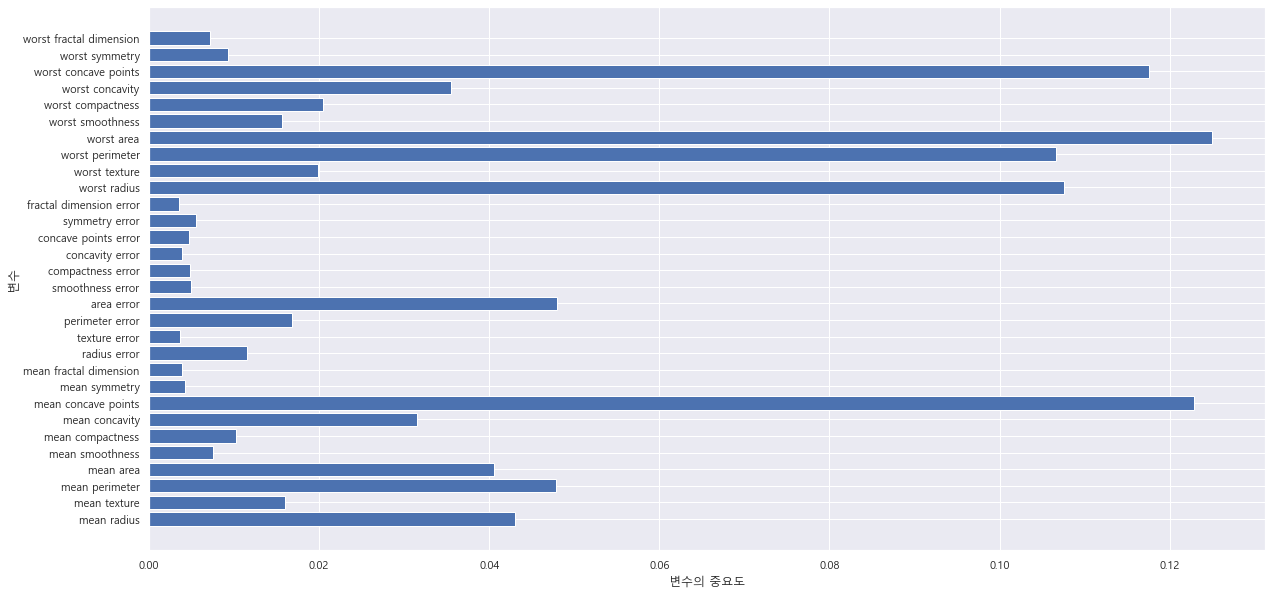

In [9]:
plt.rcParams['font.family']='Malgun Gothic' # 한글폰트
def plot_feature_importances(model):
    fig, ax = plt.subplots(1,1,figsize=(20,10))
    plt.barh(range(X_train.shape[1]), rf.feature_importances_, align='center')
    plt.yticks(np.arange(X_train.shape[1]), X_train.columns)
    plt.xlabel('변수의 중요도')
    plt.ylabel('변수')
    #plt.savefig('../../output/Feature_importance') # 그림 파일 저장
plot_feature_importances(rf)

## 2. 특성변수 permutation-based 중요도

- 특정 변수의 값을 무작위로 재정렬하여(permutation) 학습하는 경우 모델의 정확도에 영향을 얼마나 주는지를 가리키는 지표
     * model_based’ 중요도의 크기와는 다르다. 사이킷런의 Permutation-based feature importance모듈을 호출
- 예측에 영향을 미치는 입력변수의 중요도가 높은 순서대로 확인

In [10]:
from sklearn.inspection import permutation_importance
result = permutation_importance(rf, X_train, y_train, n_repeats=10, random_state=0)
result.importances_mean.round(4)
np.argsort(result.importances_mean)
X_train.columns

array([0.0018, 0.0029, 0.0009, 0.0004, 0.0022, 0.0015, 0.0013, 0.0042,
       0.0015, 0.    , 0.0013, 0.002 , 0.002 , 0.0013, 0.0015, 0.0015,
       0.0022, 0.    , 0.0007, 0.    , 0.0015, 0.0053, 0.0022, 0.0024,
       0.0026, 0.0018, 0.0029, 0.0046, 0.0015, 0.    ])

array([29, 19, 17,  9,  3, 18,  2,  6, 10, 13, 20, 15, 28, 14,  8,  5, 25,
        0, 11, 12, 16,  4, 22, 23, 24,  1, 26,  7, 27, 21], dtype=int64)

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

<AxesSubplot:xlabel='0'>

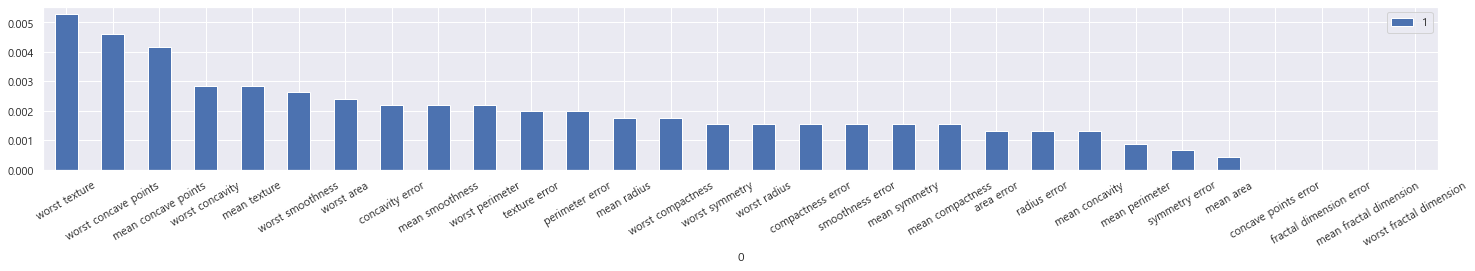

In [11]:
data = pd.DataFrame(list(zip(X_train.columns, result.importances_mean)))
data.sort_values(by =1, ascending= False, inplace =True)
data.plot(kind='bar', x=0, y=1, rot='30', figsize=(25, 3))

## 3. 특성변수 영향도(partial dependence)

- 사이킷런의 feature importance와 permutation importance는 예측에 영향을 미치는 상대적 중요도를 나타낸다. 
- pdp는 예측 확률에 어떻게 영향을 미치는지를 보여준다. 
- 전체 입력변수의 상대적인 중요도가 아닌 개별 변수의 민감도

In [12]:
X.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

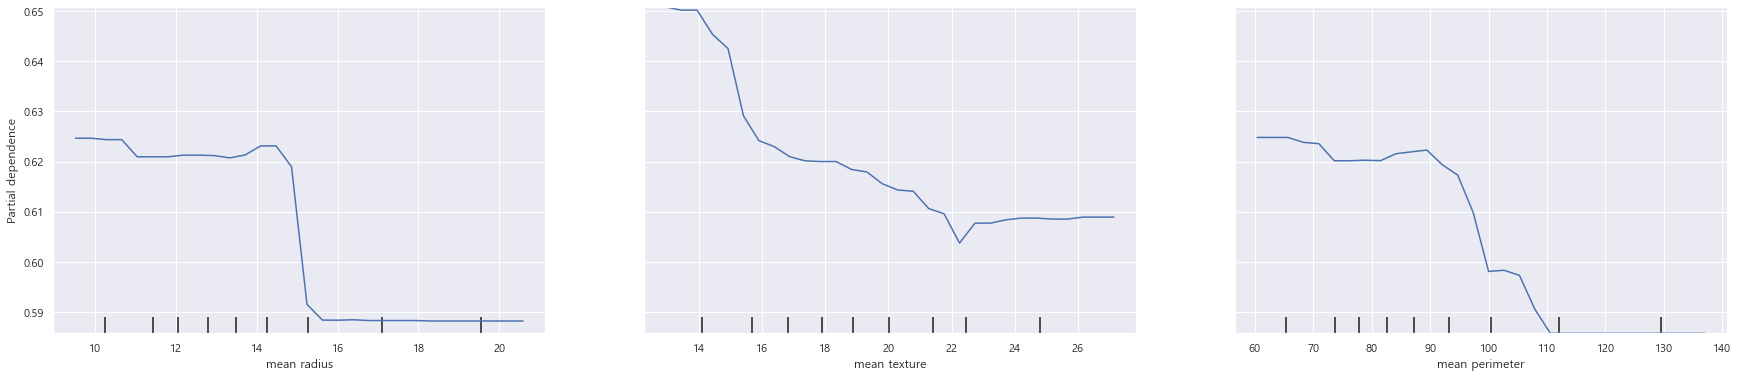

In [13]:
from sklearn.inspection import plot_partial_dependence
plt.rcParams['font.family']='Malgun Gothic' # 한글폰트
plt.rcParams['figure.figsize'] = (30,6)
features = ['mean radius', 'mean texture', 'mean perimeter']
plot_partial_dependence(rf, X_train, features, n_jobs=3, grid_resolution=30)
fig = plt.gcf(); fig.subplots_adjust(hspace=2)

In [14]:
from pdpbox import pdp, get_dataset, info_plots # pip install pdpbox
for i in ['mean radius', 'mean texture', 'mean perimeter'] :
    pdp_goals = pdp.pdp_isolate(model=rf, dataset=X_test, 
                               model_features=X_test.columns, feature=i)
    pdp.pdp_plot(pdp_goals, i)
    plt.show()

ModuleNotFoundError: No module named 'pdpbox'

SHAP 설명 (참고)
- permutaion based importance와 비교(장담점)
- https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values

# 4. SHAP 
https://github.com/slundberg/shap (설명은 여기를 보고)
https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/scatter.html (그림그리기는 여기를)

# 4.1  회귀생성 모델(Regression)

In [15]:
from sklearn.ensemble import GradientBoostingRegressor
import shap

# train an XGBoost model
X, y = shap.datasets.boston()
X.head()
y[0:10]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9])

In [16]:
# train an XGBoost model
reg = GradientBoostingRegressor(random_state=0)
model = reg.fit(X, y)

# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model) # explainer = shap.Explainer(model, X)
shap_values = explainer(X)

In [17]:
shap_values[0]

.values =
array([-3.44976095e-01,  2.10204382e-03, -2.08237769e-01, -2.59172819e-02,
       -3.84697235e-02,  1.56392418e-01,  8.03779360e-02, -1.67636219e-01,
       -8.79089969e-01, -2.17764178e-01,  5.58408295e-01,  9.73184086e-02,
        4.36241185e+00])

.base_values =
array([22.53280632])

.data =
array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [18]:
np.mean(model.predict(X)) # 모델의 예측 값
model.predict(X)[0] # 모델 예측 값의 평균
X.head(1) # 입력변수 실제 값
y[0] # target 실제 값

22.53280632411067

25.907726038912276

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1.0,296.0,15.3,396.9,4.98


24.0

## 1. 개별 자료의 예측 SHAP Value 시각화
### 1.1 폭포형태(waterfall)
- 입력변수의 색깔 : red는 양의 영향, blue는 음의 방향으로 영향
- 입력변수의 색깔의 길이 : red는 양의 영향 크기, blue는 음의 방향으로 영향 크기
- 첫번째 iinstance의 모델 예측 값 24.019, (f(x))와 모델 예측 평균 22.243, (E[f(X)])

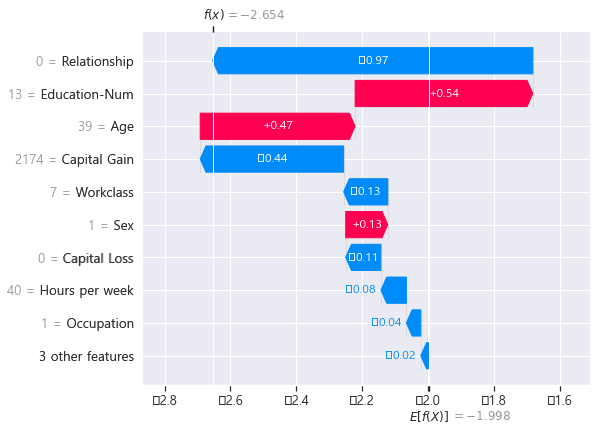

In [40]:
shap.plots.waterfall(shap_values[0])

### 2. 수평선 형태
- deeplearning의 경우 DeepExplainer를 적용하면 가능

#### Use Case
- SHAP provides multiple explainers for different kind of models.
     * TreeExplainer: Support XGBoost, LightGBM, CatBoost and scikit-learn models by Tree SHAP.
     * DeepExplainer (DEEP SHAP): Support TensorFlow and Keras models by using DeepLIFT and Shapley values.
     * GradientExplainer: Support TensorFlow and Keras models.
     * KernelExplainer (Kernel SHAP): Applying to any models by using LIME and Shapley values.

In [24]:
explainer = shap.TreeExplainer(model) 
shap_values = explainer.shap_values(X)

In [25]:
shap_values[0]

array([-3.44976095e-01,  2.10204382e-03, -2.08237769e-01, -2.59172819e-02,
       -3.84697235e-02,  1.56392418e-01,  8.03779360e-02, -1.67636219e-01,
       -8.79089969e-01, -2.17764178e-01,  5.58408295e-01,  9.73184086e-02,
        4.36241185e+00])

In [26]:
# visualize the first prediction's explanation with a force plot
shap.initjs()
shap.plots.force(explainer.expected_value, shap_values[0])

## 2. 전체 자료(특성변수)의 SHAP value 시각화

If we take many force plot explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset (in the notebook this plot is interactive):

In [27]:
shap.force_plot(explainer.expected_value, shap_values) # shap.force_plot(explainer.expected_value, shap_values, X)

Visualize the sub set of dataset

In [28]:
shap.force_plot(explainer.expected_value, shap_values[:1,:])
shap_values[:1,:]; X.iloc[:1,:]

array([[-3.44976095e-01,  2.10204382e-03, -2.08237769e-01,
        -2.59172819e-02, -3.84697235e-02,  1.56392418e-01,
         8.03779360e-02, -1.67636219e-01, -8.79089969e-01,
        -2.17764178e-01,  5.58408295e-01,  9.73184086e-02,
         4.36241185e+00]])

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1.0,296.0,15.3,396.9,4.98


In [29]:
shap.force_plot(explainer.expected_value, shap_values[88:89,:], X.iloc[88:89,:])
shap_values[88:89,:]; X.iloc[88:89,:]

array([[-0.2995802 , -0.01303583,  0.07436728, -0.03135194,  0.32218108,
         4.02883667, -1.18029547, -0.67356285, -0.41844564, -0.15490786,
         0.5036041 , -0.01274926,  1.8388036 ]])

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
88,0.0566,0.0,3.41,0.0,0.489,7.007,86.3,3.4217,2.0,270.0,17.8,396.9,5.5


In [30]:
shap.force_plot(explainer.expected_value, shap_values[:89,:], X.iloc[:89,:])

### 모든 데이터(features, targets)의 SHAP value

In [31]:
data = pd.DataFrame(shap_values, columns = X.columns)
data['Predictions'] = model.predict(X)
data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Predictions
0,-0.344976,0.002102,-0.208238,-0.025917,-0.038470,0.156392,0.080378,-0.167636,-0.879090,-0.217764,0.558408,0.097318,4.362412,25.907726
1,-0.232983,-0.010574,-0.169842,-0.031352,0.306606,-1.780697,-0.402697,-0.612653,-0.147226,0.153536,0.609897,0.086489,1.661891,21.963202
2,-0.233545,-0.010574,-0.169601,-0.036553,0.553608,5.837946,0.229921,-0.598768,-0.171439,0.154029,0.177500,0.142956,5.518833,33.927122
3,-0.298436,-0.011293,-0.067120,-0.040652,0.477803,4.686638,0.354409,-0.702674,-0.027387,1.270849,-0.037182,0.141544,5.865975,34.145281
4,0.382559,-0.009038,0.039684,-0.013397,0.473424,5.758548,0.504677,-0.481783,-0.027387,1.734663,0.222358,0.087423,4.208142,35.412679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,-0.071910,-0.043037,0.005117,-0.029319,0.260607,1.082080,-0.084910,0.340411,-0.799420,-0.212309,-1.627443,0.186868,0.647422,22.186962
502,-0.253745,-0.043037,-0.016915,-0.031352,0.111691,-1.579946,-0.536101,0.119385,-0.845573,-0.179843,-1.471028,0.134091,1.755603,19.696036
503,-0.312328,-0.045498,0.002128,-0.031352,0.289152,4.019621,-0.865821,0.244700,-0.995047,-0.194788,-1.879666,0.107754,1.855802,24.727462
504,0.331949,-0.041716,0.002154,-0.031352,0.208147,0.859643,-0.546732,0.163185,-0.995047,-0.183913,-1.627624,0.157224,2.528440,23.357164


### SHAP summary plot 해석하기

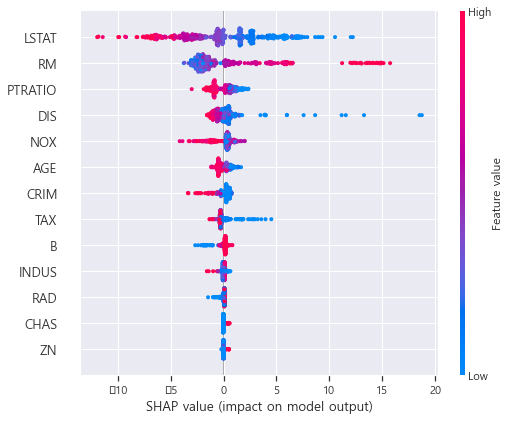

In [32]:
shap.summary_plot(shap_values, X)

# 4.2  분류 모델(Classification)
https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/scatter.html (그림그리기는 여기를)

The classic UCI adult income dataset (which is a classification task to predict if people made over \$50k in the 90s).

In [33]:
from sklearn.ensemble import GradientBoostingClassifier

# train XGBoost model
X,y = shap.datasets.adult()
X.head()
y[0:10]

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


array([False, False, False, False, False, False, False,  True,  True,
        True])

In [34]:
clf = GradientBoostingClassifier()
model = clf.fit(X, y)

# compute SHAP values
explainer = shap.Explainer(model, X) # explainer = shap.Explainer(model)
shap_values = explainer(X[:1000])

### Simple dependence scatter plot
- A dependence scatter plot shows the effect a single feature has on the predictions made by the model. 
- In this example the log-odds of making over 50k increases significantly between age 20 and 40.

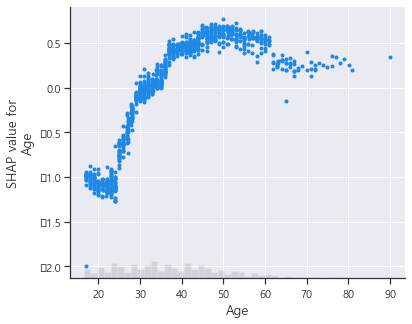

In [35]:
shap.plots.scatter(shap_values[:,"Age"])

- Each dot is a single prediction (row) from the dataset.
- The x-axis is the value of the feature (from the X matrix, stored in shap_values.data).
- The y-axis is the SHAP value for that feature (stored in shap_values.values), which represents how much knowing that feature’s value changes the output of the model for that sample’s prediction. For this model the units are log-odds of making over 50k annually.
- The light grey area at the bottom of the plot is a histogram showing the distribution of data values.

### Using color to highlight interaction effects

- The vertical dispersion in the plot above shows that the same value for the Age feature can have a different impact on the model's output for different people. This means there are non-linear interaction effects in the model between Age and other features (otherwise the scatter plot would perfectly follow the line given by shap.plots.partial_dependence).

- To show which feature may be driving these interaction effects we can color our Age dependence scatter plot by another feature. 
- If we pass the entire Explanation object to the color parameter then the scatter plot attempts to pick out the feature column with the strongest interaction with Age. If an interaction effect is present between this other feature and the feature we are plotting it will show up as a distinct vertical pattern of coloring. 
- For the example below, 20-year-olds with a high level of education are less likely make over \$50k than 20-year-olds with a low level of education. This suggests an interaction effect between Education-Num and Age.

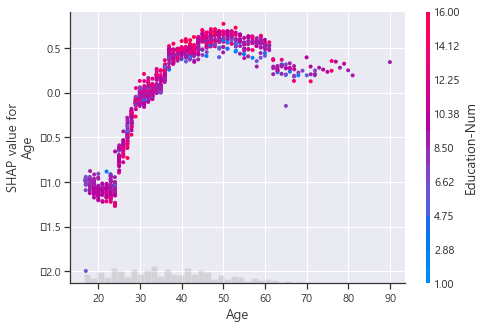

In [36]:
shap.plots.scatter(shap_values[:, "Age"], color=shap_values)

To explicitly control which feature is used for coloring you can pass a specific feature column to the color parameter.

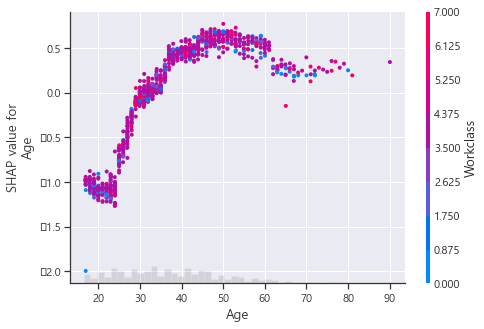

In [37]:
shap.plots.scatter(shap_values[:, "Age"], color=shap_values[:,"Workclass"])

In the plot above we see that the Workclass feature is encoded with a number for the sake of the XGBoost model. When plotting though we often would rather use the original string values before they were categorically encoded. To do this we can set the .display_data property of the Explanation object to a parallel version of the data we would like displayed in plots.

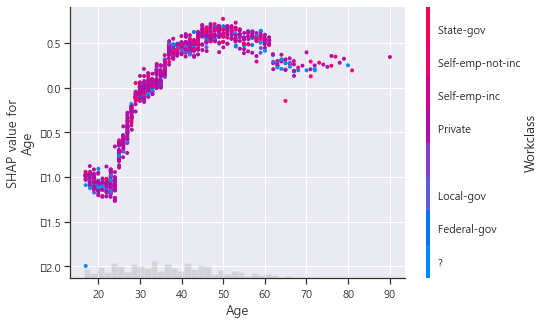

In [38]:
X_display,y = shap.datasets.adult(display=True)
shap_values.display_data = X_display.values

shap.plots.scatter(shap_values[:, "Age"], color=shap_values[:,"Workclass"])

### Exploring different interaction colorings
- we can use shap.approximate_interactions to guess which features may interact with age. 
-  we can make plots colored by each of the top three possible interacting features

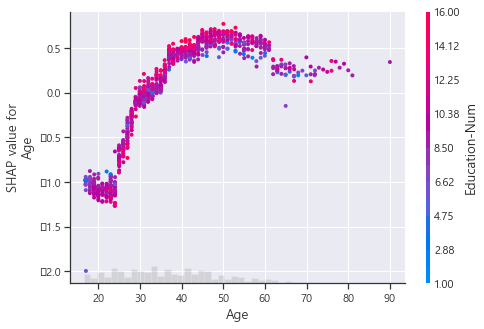

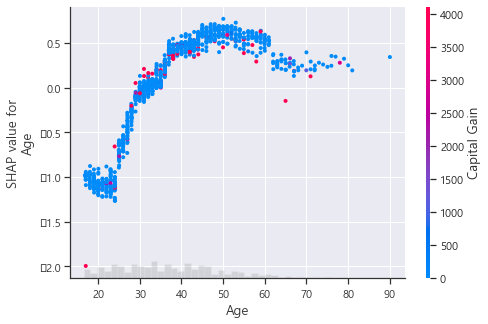

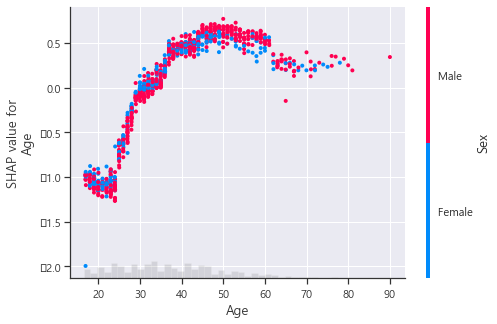

In [39]:
inds = shap.utils.potential_interactions(shap_values[:, "Age"], shap_values)
for i in range(3):
    shap.plots.scatter(shap_values[:,"Age"], color=shap_values[:,inds[i]])

### Using global feature importance orderings
Sometimes we don’t know the name or index of the feature we want to plot, we just want to plot the most important features. To do that we can use the dot-chaining capability of the Explanation object to compute a measure of global feature importance, sort by that measure (descending), and then pick out the top feature (which in this case is Age):

# End